In [237]:
%%writefile Dashboardapp.py

import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


Overwriting Dashboardapp.py


In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [200]:
sugar_data = pd.read_csv('/content/drive/MyDrive/Data/psd_sugar.csv')
delhi_weather = pd.read_csv('/content/drive/MyDrive/Data/Delhi_NCR_1990_2022_Safdarjung.csv')
lucknow_weather = pd.read_csv('/content/drive/MyDrive/Data/Lucknow_1990_2022.csv')
mumbai_weather = pd.read_csv('/content/drive/MyDrive/Data/Mumbai_1990_2022_Santacruz.csv')
sugar_price = pd.read_csv('/content/drive/MyDrive/Data/PSUGAISAUSDM.csv')

In [128]:
delhi_weather.rename(columns={'time': 'Date'}, inplace=True)
delhi_weather.rename(columns={'tavg': 'Delhi_avg_weather'}, inplace=True)
delhi_weather.rename(columns={'prcp': 'Delhi_prcp'}, inplace=True)

In [129]:
delhi_weather['Date'] = pd.to_datetime(delhi_weather['Date'], dayfirst=True, errors='coerce')

#clean version of delhi weather
delhi_weather_data = delhi_weather[['Date', 'Delhi_avg_weather', 'Delhi_prcp']]

In [130]:
lucknow_weather.rename(columns={'time': 'Date'}, inplace=True)
lucknow_weather.rename(columns={'tavg': 'Lucknow_avg_weather'}, inplace=True)
lucknow_weather.rename(columns={'prcp': 'Lucknow_prcp'}, inplace=True)

In [131]:

lucknow_weather['Date'] = pd.to_datetime(lucknow_weather['Date'], dayfirst=True, errors='coerce')

#clean version of lucknow weather
lucknow_weather_data = lucknow_weather[['Date', 'Lucknow_avg_weather', 'Lucknow_prcp']]

In [132]:
mumbai_weather.rename(columns={'time': 'Date'}, inplace=True)
mumbai_weather.rename(columns={'tavg': 'Mumbai_avg_weather'}, inplace=True)
mumbai_weather.rename(columns={'prcp': 'Mumbai_prcp'}, inplace=True)

In [133]:
mumbai_weather['Date'] = pd.to_datetime(mumbai_weather['Date'], dayfirst=True, errors='coerce')


#clean version of mumabi weather
mumbai_weather_data = mumbai_weather[['Date', 'Mumbai_avg_weather', 'Mumbai_prcp']]

In [134]:
mumbai_lucknow_weather = pd.merge(mumbai_weather_data, lucknow_weather_data, on='Date')
india_weather = pd.merge(mumbai_lucknow_weather, delhi_weather_data, on='Date')

In [135]:
india_weather['Date'] = pd.to_datetime(india_weather['Date'])

india_weather.set_index('Date', inplace=True)




In [136]:
countries= ['Brazil', 'India']

sugar_data.rename(columns={'Calendar_Year': 'Date'}, inplace=True)
sugar_data.rename(columns={'Value': 'Total_Cane_Sugar_Production_1000MT'}, inplace=True)

In [137]:
sugar_data['Date'] = pd.to_datetime(sugar_data['Date'], format='%Y', errors='coerce')

brl_inr = sugar_data[sugar_data['Country_Name'].isin(countries)]
sugar_brl_inr = brl_inr[brl_inr['Attribute_Description'] == 'Cane Sugar Production']


#Clear version of brazil and India total sugar production from 1960
brazil_india_sugar = sugar_brl_inr[['Date','Country_Name', 'Total_Cane_Sugar_Production_1000MT']]


In [138]:
brazil_india_sugar = brazil_india_sugar.copy()
brazil_india_sugar.loc[:, 'Date'] = pd.to_datetime(brazil_india_sugar['Date'])
brazil_india_sugar.set_index('Date', inplace=True)




In [146]:
brazil_india_sugar = brazil_india_sugar.groupby('Date').sum()


In [147]:
daily_sugar_production = brazil_india_sugar.resample('D').ffill()
daily_sugar_production['daily_production'] = daily_sugar_production['Total_Cane_Sugar_Production_1000MT'] / 365
daily_sugar_production = daily_sugar_production[['daily_production']]

In [213]:

print(sugar_price.head())
sugar_price.columns

                  US_Cents_per_Pound_sugar
observation_date                          
1990-01-01                       14.200001
1990-02-01                       14.650002
1990-03-01                       15.310001
1990-04-01                       15.240002
1990-05-01                       14.619999


Index(['US_Cents_per_Pound_sugar'], dtype='object')

In [209]:
sugar_price.rename(columns={'PSUGAISAUSDM': 'US_Cents_per_Pound_sugar'}, inplace=True)

In [211]:
sugar_price['observation_date'] = pd.to_datetime(sugar_price['observation_date'], errors='coerce')


In [212]:
sugar_price.set_index('observation_date', inplace=True)


0


In [215]:

daily_sugar_price = sugar_price.resample('D').interpolate(method='linear')

In [216]:

daily_features = pd.merge(india_weather, daily_sugar_production, left_index=True, right_index=True, how='inner')
daily_data = pd.merge(daily_features, daily_sugar_price, left_index=True, right_index=True, how='inner')

daily_data.head(5)

,Mumbai_avg_weather,Mumbai_prcp,Lucknow_avg_weather,Lucknow_prcp,Delhi_avg_weather,Delhi_prcp,daily_production,US_Cents_per_Pound_sugar
1990-01-01,23.2,0.0,7.2,0.0,9.4,0.0,59.19726,14.200001
1990-01-02,22.2,0.0,10.5,0.0,9.3,0.0,59.19726,14.214517
1990-01-03,21.8,0.0,10.2,NaN,9.0,0.0,59.19726,14.229033
1990-01-04,25.4,0.0,9.1,0.0,10.7,0.0,59.19726,14.243549
1990-01-05,26.5,0.0,13.5,0.0,12.6,0.0,59.19726,14.258065


In [217]:
x = daily_data.drop(columns=['US_Cents_per_Pound_sugar'])
y = daily_data['US_Cents_per_Pound_sugar']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 3.5410748285334797


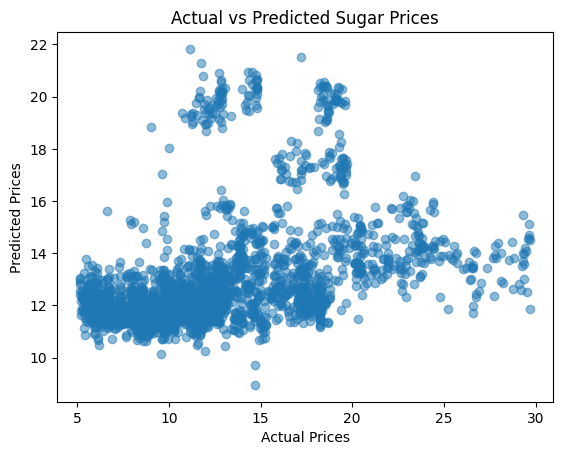

In [218]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Sugar Prices")
plt.show()



In [226]:
daily_data['forecasted_price'] = pipeline.predict(x)
daily_data['adjusted_price'] = (1.03 * daily_data['forecasted_price']) + (0.2 * daily_data['forecasted_price'])

In [236]:

st.title("Sugar Price Forecast Dashboard")
col1, col2 = st.columns(2)
today_forecast = daily_data['forecasted_price'].iloc[-1]  # Last row as today's forecast
today_adjusted = daily_data['adjusted_price'].iloc[-1]  # Last row as today's adjusted price


with col1:
    st.metric("Today's Forecasted Price (US Cents/Lb)", round(today_forecast, 2))

with col2:
    st.metric("Today's Adjusted Price (US Cents/Lb)", round(today_adjusted, 2))

st.subheader("Forecasted vs Adjusted Prices")
st.line_chart(daily_data[['forecasted_price', 'adjusted_price']])

# Data Display
st.subheader("Detailed Data")
st.dataframe(daily_data[['forecasted_price', 'adjusted_price', 'US_Cents_per_Pound_sugar']])

2024-12-20 01:41:27.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.332 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 01:41:27.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()